# Notebook for Wine Analysis

UMN Bootcamp Project 1 - Group 6

In [1]:
import pandas as pd
import re
import gmaps
from config import g_key
import numpy as py
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress
import requests
import json

gmaps.configure(api_key=g_key)

In [2]:
wine_data_file = "Resources/wine_data.csv"
wine_data = pd.read_csv(wine_data_file, encoding="utf-8")

wine_data.head()

,Unnamed: 0,country,description,designation,points,price (USD),province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,345,Australia,This wine contains some material over 100 year...,Rare,100,350.0,Victoria,Rutherglen,NaN,Joe Czerwinski,@JoeCz,Chambers Rosewood Vineyards NV Rare Muscat (Ru...,Muscat,Chambers Rosewood Vineyards
1,7335,Italy,Thick as molasses and dark as caramelized brow...,Occhio di Pernice,100,210.0,Tuscany,Vin Santo di Montepulciano,NaN,NaN,NaN,Avignonesi 1995 Occhio di Pernice (Vin Santo ...,Prugnolo Gentile,Avignonesi
2,36528,France,This is a fabulous wine from the greatest Cham...,Brut,100,259.0,Champagne,Champagne,NaN,Roger Voss,@vossroger,Krug 2002 Brut (Champagne),Champagne Blend,Krug
3,39286,Italy,"A perfect wine from a classic vintage, the 200...",Masseto,100,460.0,Tuscany,Toscana,NaN,NaN,NaN,Tenuta dell'Ornellaia 2007 Masseto Merlot (Tos...,Merlot,Tenuta dell'Ornellaia
4,42197,Portugal,This is the latest release of what has long be...,Barca-Velha,100,450.0,Douro,NaN,NaN,Roger Voss,@vossroger,Casa Ferreirinha 2008 Barca-Velha Red (Douro),Portuguese Red,Casa Ferreirinha


In [3]:
# Drop region 2, taster name, taster twitter handle, and unnamed column and ensure dataframe is clean/usable
clean_wine_data = wine_data.drop(["region_2", "taster_name", "taster_twitter_handle", "Unnamed: 0"], axis = 1)

# Extract the year from the title column and place it into a new column
# This is using the string extract function
clean_wine_data["Year"] = clean_wine_data["title"].str.extract("(\d{4})")

# Drop any rows that do not have a price, country, rating, or year
cleaned_wine_data = clean_wine_data.dropna(subset = ["price (USD)", "country", "points", "Year"])
cleaned_wine_data.head()

,country,description,designation,points,price (USD),province,region_1,title,variety,winery,Year
1,Italy,Thick as molasses and dark as caramelized brow...,Occhio di Pernice,100,210.0,Tuscany,Vin Santo di Montepulciano,Avignonesi 1995 Occhio di Pernice (Vin Santo ...,Prugnolo Gentile,Avignonesi,1995
2,France,This is a fabulous wine from the greatest Cham...,Brut,100,259.0,Champagne,Champagne,Krug 2002 Brut (Champagne),Champagne Blend,Krug,2002
3,Italy,"A perfect wine from a classic vintage, the 200...",Masseto,100,460.0,Tuscany,Toscana,Tenuta dell'Ornellaia 2007 Masseto Merlot (Tos...,Merlot,Tenuta dell'Ornellaia,2007
4,Portugal,This is the latest release of what has long be...,Barca-Velha,100,450.0,Douro,NaN,Casa Ferreirinha 2008 Barca-Velha Red (Douro),Portuguese Red,Casa Ferreirinha,2008
5,Italy,"This gorgeous, fragrant wine opens with classi...",Riserva,100,550.0,Tuscany,Brunello di Montalcino,Biondi Santi 2010 Riserva (Brunello di Montal...,Sangiovese,Biondi Santi,2010


In [4]:
# Create a cleaned up version of the df for further analysis
wine_df = cleaned_wine_data.copy()

# Change Georgia to Georgia Country to ensure Google finds lat, lng for the country of Georgia instead of the state
wine_df["country"] = wine_df["country"].replace(["Georgia"], "Georgia Country")

# Drop rows where year is less than 1900 and greater than 2020
wine_df["Year"] = wine_df["Year"].astype("int")

# Remove outlier years
wine_df = wine_df[(wine_df["Year"] >= 1980) & (wine_df["Year"] <= 2020)]

wine_df

,country,description,designation,points,price (USD),province,region_1,title,variety,winery,Year
1,Italy,Thick as molasses and dark as caramelized brow...,Occhio di Pernice,100,210.0,Tuscany,Vin Santo di Montepulciano,Avignonesi 1995 Occhio di Pernice (Vin Santo ...,Prugnolo Gentile,Avignonesi,1995
2,France,This is a fabulous wine from the greatest Cham...,Brut,100,259.0,Champagne,Champagne,Krug 2002 Brut (Champagne),Champagne Blend,Krug,2002
3,Italy,"A perfect wine from a classic vintage, the 200...",Masseto,100,460.0,Tuscany,Toscana,Tenuta dell'Ornellaia 2007 Masseto Merlot (Tos...,Merlot,Tenuta dell'Ornellaia,2007
4,Portugal,This is the latest release of what has long be...,Barca-Velha,100,450.0,Douro,NaN,Casa Ferreirinha 2008 Barca-Velha Red (Douro),Portuguese Red,Casa Ferreirinha,2008
5,Italy,"This gorgeous, fragrant wine opens with classi...",Riserva,100,550.0,Tuscany,Brunello di Montalcino,Biondi Santi 2010 Riserva (Brunello di Montal...,Sangiovese,Biondi Santi,2010
...,...,...,...,...,...,...,...,...,...,...,...
129965,US,"Simple but refreshing and crisp, with nice gra...",Dry,80,16.0,Missouri,Missouri,Montelle 2008 Dry Vignoles (Missouri),Vignoles,Montelle,2008
129966,US,This Chardonnay-Viognier blend is slightly swe...,Devil's Daughter,80,25.0,California,Contra Costa County,Bloomfield 2008 Devil's Daughter White (Contra...,White Blend,Bloomfield,2008
129967,US,"While there's some nice, honest fruit here, it...",NaN,80,14.0,Missouri,Missouri,Montelle 2008 Chambourcin (Missouri),Chambourcin,Montelle,2008
129969,US,"Short and slightly sweet, there's nutty overto...",Proprietor's Reserve,80,13.0,Pennsylvania,Pennsylvania,Chaddsford 2007 Proprietor's Reserve White (Pe...,White Blend,Chaddsford,2007


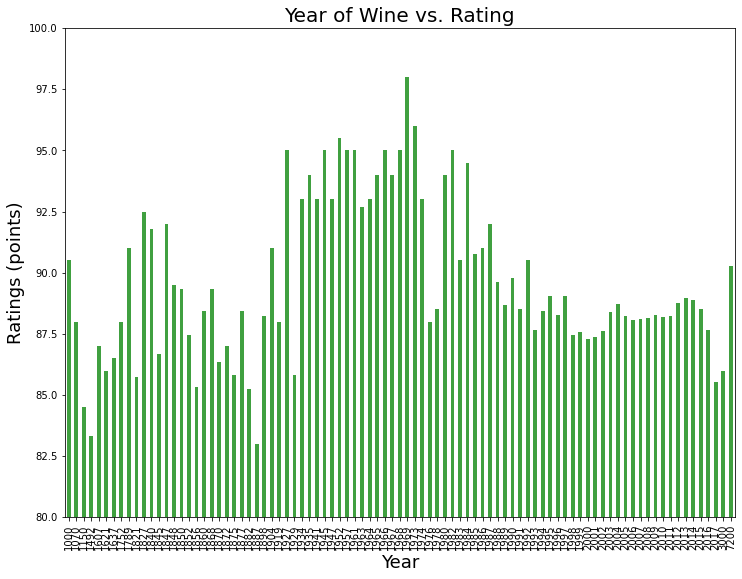

In [11]:
# Analyze and plot year of wine vs. rating
# Scatter plot vs. bar plot?? 
#Discuss with full group
wine_year = wine_df.groupby(["Year"])
total_ratings = wine_df.groupby(["Year"]).mean()["points"]

total_ratings.plot(kind="bar", figsize = (12,9), color="g", alpha=0.75, legend=False, rot = 90)

plt.ylim(80, 100)

#Assign labels and chart title
plt.title("Year of Wine vs. Rating", fontsize = 20)
plt.xlabel("Year", fontsize = 18)
plt.ylabel("Ratings (points)", fontsize = 18)
plt.ylim(80,100)

# Identify how to set tick locations - Ciera
# x_axis = np.arange(len(wine_year))
# tick_locations = [value for value in x_axis]
# plt.xticks(tick_locations)


plt.show()

The r-squared is: 0.4164146575658631


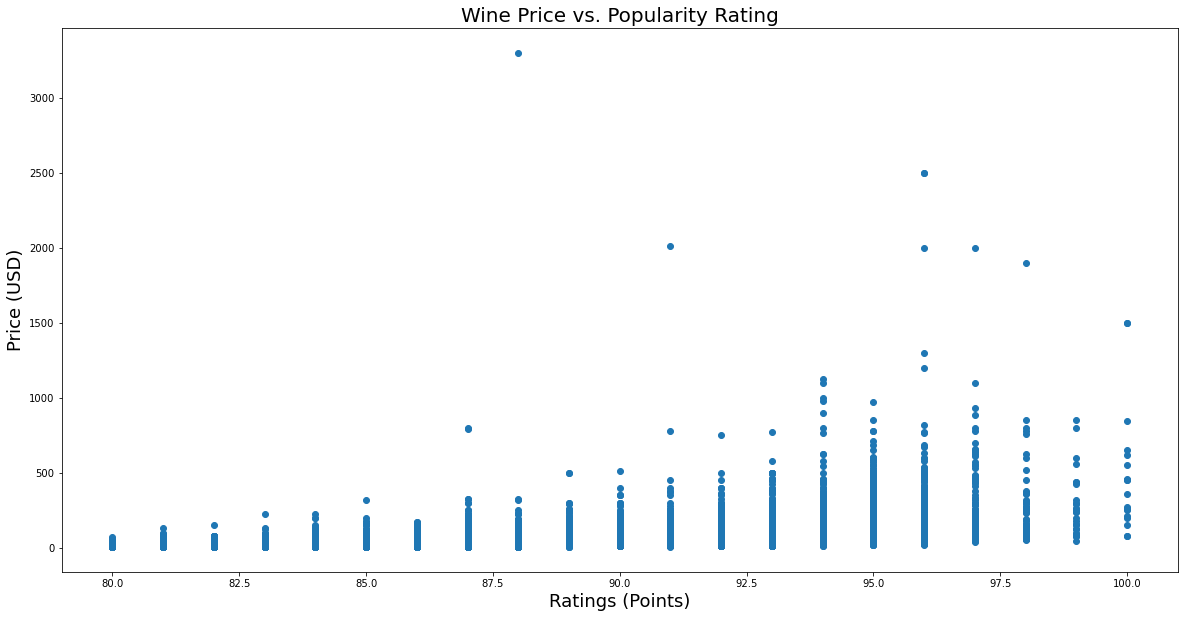

In [15]:
# Analyze price of wine vs. rating
# Scatter plot
#Define variables
price = wine_df["price (USD)"]
ratings = wine_df["points"]

#plot figure
plt.figure(figsize = (20,10))
plt.scatter(ratings, price)

#assign labels and chart title
plt.title(f"Wine Price vs. Popularity Rating", fontsize = 20)
plt.xlabel("Ratings", fontsize = 18)
plt.ylabel("Price (USD)", fontsize =18)

# Analyze price of wine vs. rating Linear Regression
x_values= wine_df["points"]
y_values = wine_df["price (USD)"]

# Create the linregress function
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(80,1500),fontsize=28,color="red")
print(f"The r-squared is: {rvalue}")
plt.savefig('output_data/Price_Rating_linear_MT.png')

plt.show()

The r-squared is: -0.07977748655330845


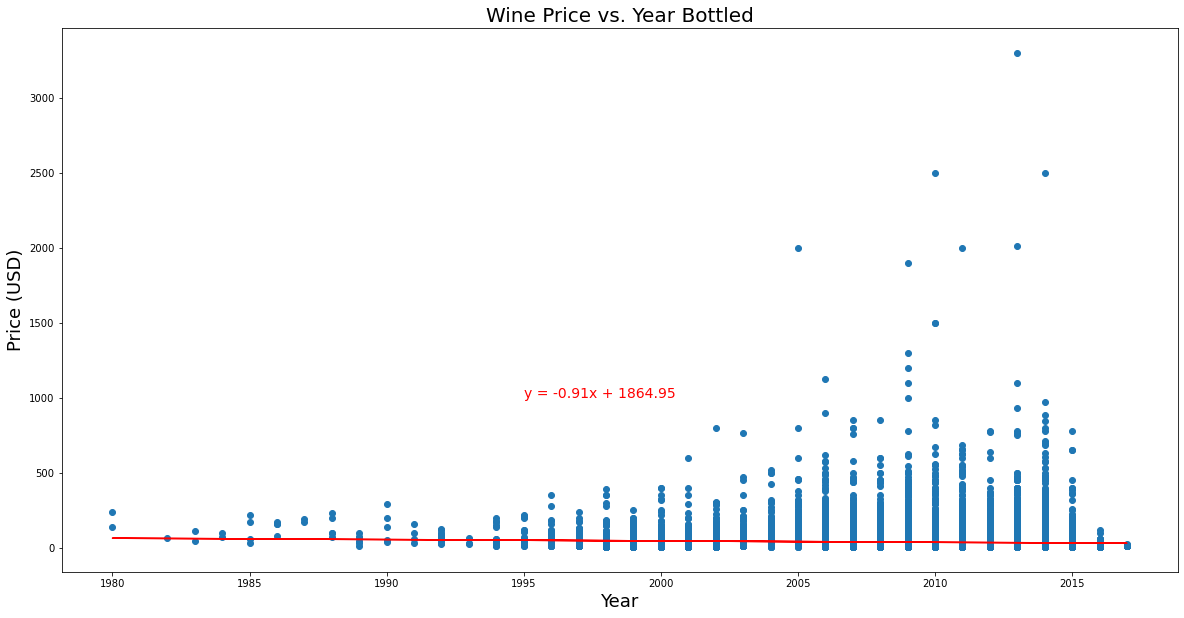

In [17]:
# Analyze price of wines in the 2000's
# Scatter plot
#Define variables
year = wine_df["Year"]
price = wine_df["price (USD)"]

#plot figure
plt.figure(figsize = (20,10))
plt.scatter(year, price)

#Assign labels and chart title
plt.title(f"Wine Price vs. Year Bottled", fontsize = 20)
plt.xlabel("Year", fontsize = 18)
plt.ylabel("Price (USD)", fontsize = 18)

# Analyze year of wine vs. price Linear Regression
x_values = wine_df["Year"].astype("float")
y_values = wine_df["price (USD)"]

# Create the linregress function
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(1995,1000),fontsize=14,color="red")
# plt.xlabel("Year", fontsize = 10)
# plt.ylabel("Price (USD)", fontsize = 10)
# plt.title(f"Wine Price vs. Year Bottled", fontsize = 14)
print(f"The r-squared is: {rvalue}")
plt.savefig('output_data/Year_Price_linear_MT.png')

plt.show()

In [18]:
# Create a summary df for price and wine rating

# Declare the avg wine price and avg rating by country
avg_price = wine_df.groupby("country").mean()["price (USD)"]
avg_rating = wine_df.groupby("country").mean()["points"]

# Summary DF
wine_country = pd.DataFrame({
    "Avg Wine Price (USD)": avg_price,
    "Avg Wine Rating": avg_rating
})

In [9]:
# Retrieve lat and lng for the countries in Wine_DF through Google Maps API
wine_country["lat"] = ""
wine_country["lng"] = ""

params = {"key": g_key}


for index, row in wine_country.iterrows():   
    
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    
    country = index
    
    params["address"] = f"{country}"
    
    country_lat_lng = requests.get(base_url, params=params)

    # print the response URL, avoid doing for public GitHub repos in order to avoid exposing key
    # print(response.url)

    # Convert to JSON
    country_geo = country_lat_lng.json()

    # Extract lat/lng
    wine_country.loc[index, "lat"] = country_geo["results"][0]["geometry"]["location"]["lat"]
    wine_country.loc[index, "lng"] = country_geo["results"][0]["geometry"]["location"]["lng"]
    
# Show new df
wine_country

,Avg Wine Price (USD),Avg Wine Rating,lat,lng
country,,,,
Argentina,24.606314,86.741230,-38.4161,-63.6167
Armenia,14.500000,87.500000,40.0691,45.0382
Australia,35.097528,88.595506,-25.2744,133.775
Austria,30.776573,90.210774,47.5162,14.5501
Bosnia and Herzegovina,12.500000,86.500000,43.9159,17.6791
Brazil,23.631579,84.394737,-14.235,-51.9253
Bulgaria,14.645390,87.936170,42.7339,25.4858
Canada,35.723320,89.379447,56.1304,-106.347
Chile,20.773628,86.506263,-35.6751,-71.543


In [10]:
# Identify the top 10 most expensive wine countries
most_expensive = wine_country.sort_values(["Avg Wine Price (USD)"], ascending = False)
most_expensive

,Avg Wine Price (USD),Avg Wine Rating,lat,lng
country,,,,
Switzerland,85.285714,88.571429,46.8182,8.22751
England,52.400000,91.709091,52.3555,-1.17432
Germany,42.385640,89.844508,51.1657,10.4515
Hungary,41.253521,89.267606,47.1625,19.5033
Italy,40.665835,88.718713,41.8719,12.5674
France,40.554871,88.741333,46.2276,2.21375
US,36.840300,88.602842,37.0902,-95.7129
Canada,35.723320,89.379447,56.1304,-106.347
Australia,35.097528,88.595506,-25.2744,133.775


In [11]:
# Storing variables for gmap use
locations = wine_country[["lat", "lng"]]
country_rating = wine_country["Avg Wine Rating"].astype(float)
country_price = wine_country["Avg Wine Price (USD)"].astype(float)

In [12]:
# Identify countries with the most expensive wine
# Avg wine price by country
# Include a gmap
fig = gmaps.figure()

price_layer = gmaps.heatmap_layer(locations, weights=country_price,
                                dissipating=False, max_intensity=10,
                                point_radius=1)

fig.add_layer(price_layer)

fig


Figure(layout=FigureLayout(height='420px'))

In [13]:
# Identify countries with the highest rated wine
# Avg wine ratings by country
# Include a gmap
fig = gmaps.figure()

rating_layer = gmaps.heatmap_layer(locations, weights=country_rating,
                                dissipating=False, max_intensity=10,
                                point_radius=2)

fig.add_layer(rating_layer)

fig

# Need a way to reduce the scale that weights are compared to - Laura


Figure(layout=FigureLayout(height='420px'))